In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yastn
import yastn.tn.mps as mps
from routines_new import Hamiltonian_dpt_4U_position, Hamiltonian_dpt_4U_momentum, Hamiltonian_dpt_4U_mixed, local_operators


In [22]:
NW = 4
D = 32
U = 3.05
vS = 0.25
alpha = 0.7
sym = 'Z2'
nn = 0 if sym == 'Z2' else NW + 2

H0, s2i, i2s = Hamiltonian_dpt_4U_position(NW, 0, 0, [0, 10000], 0, U * (2 * alpha - 1), sym=sym)
qI, qc, qcp, qn, dx, dn1, dn2, dI, m12, m21 = local_operators(sym=sym)
psi = mps.random_mps(H0, n=nn)
opts_svd = {"D_total": D}
info = mps.dmrg_(psi, H0, method='2site', opts_svd=opts_svd, max_sweeps=100, Schmidt_tol=1e-10)
print(info)

sd = s2i['D1']
O = (np.sqrt(alpha) * dn1 + np.sqrt(1 - alpha) * m12)
O = mps.product_mpo(sd * [qI] + [O] + (len(H0) - 1 - sd) * [qI])
psi = O @ psi
psi.canonize_(to='last')
psi.canonize_(to='first')

print(mps.measure_1site(psi, dn1, psi, sites=sd))
print(mps.measure_1site(psi, dn2, psi, sites=sd))
oo = mps.measure_1site(psi, qn, psi, sites=list(range(1, len(H0) + 1)))


DMRG_out(sweeps=100, method='2site', energy=-7.369464406843401, denergy=7.815970093361102e-13, max_dSchmidt=1.781830742811016e-08, max_discarded_weight=np.float64(0.00024856242885522414))
0.7000000000000012
0.3000000000000005


In [ ]:
H1, s2i, i2s = Hamiltonian_dpt_4U_position(NW, 0, 0, [0, 0], 0, U, sym=sym)
H2, s2i, i2s = Hamiltonian_dpt_4U_position(NW, 0, 0, [0, 0], vS, U, sym=sym)
dt = 0.06126
tswitch, tfin = 2, 6

times = np.linspace(0, 8, 33)
traces = {'n1': [], 'n2': [], 'm12': [], 'S1': [], 'S2': [], 'S3': [], 'S4': [], 'ent0': [], 'entS': []}
ts = []

for t0, t1, H in [(0, tswitch, H1), (tswitch, tfin, H2)]:
    times = np.linspace(t0, t1, int((t1 - t0) * 4) + 1)
    for step in mps.tdvp_(psi, H, times, method='2site', dt=dt, opts_svd=opts_svd, yield_initial=True):
        print(step)
        ts.append(step.tf)
        traces['n1'].append(mps.measure_1site(psi, dn1, psi, sites=sd).real)
        traces['n2'].append(mps.measure_1site(psi, dn2, psi, sites=sd).real)
        traces['m12'].append(mps.measure_1site(psi, m12, psi, sites=sd).real)
        for ind in ['S1', 'S2', 'S3', 'S4']:
            traces[ind].append(mps.measure_1site(psi, qn, psi, sites=s2i[ind]).real)

        ent = psi.get_entropy()
        traces['ent0'].append(ent[sd+1])
        traces['entS'].append(ent[s2i['S2']+1])


TDVP_out(ti=np.float64(0.0), tf=np.float64(0.0), time_independent=True, dt=0.06126, steps=0)
TDVP_out(ti=np.float64(0.0), tf=np.float64(0.25), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(0.25), tf=np.float64(0.49999999999999994), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(0.5), tf=np.float64(0.7500000000000002), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(0.75), tf=np.float64(1.0000000000000002), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(1.0), tf=np.float64(1.2500000000000002), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(1.25), tf=np.float64(1.5000000000000002), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(1.5), tf=np.float64(1.7500000000000002), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(1.75), tf=np.float64(2.0), time_independent=True, dt=np.float64(0.05), step

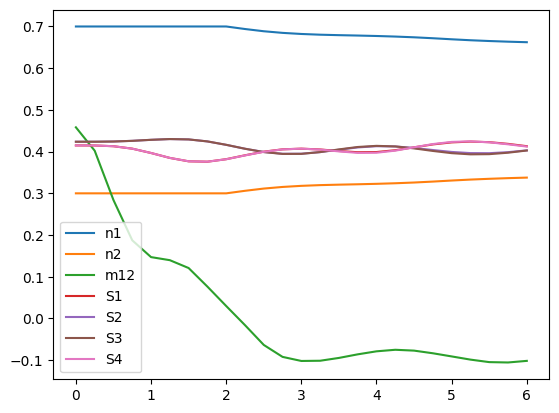

In [7]:
for k in ['n1', 'n2', 'm12', 'S1', 'S2', 'S3', 'S4']:
    plt.plot(ts, traces[k], label=k)
plt.legend()

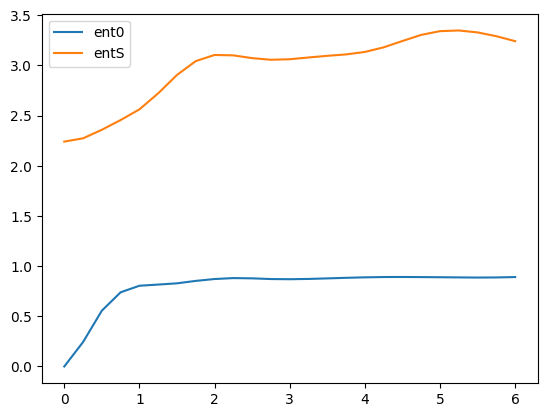

In [8]:
for k in ['ent0', 'entS']:
    plt.plot(ts, traces[k], label=k)
plt.legend()

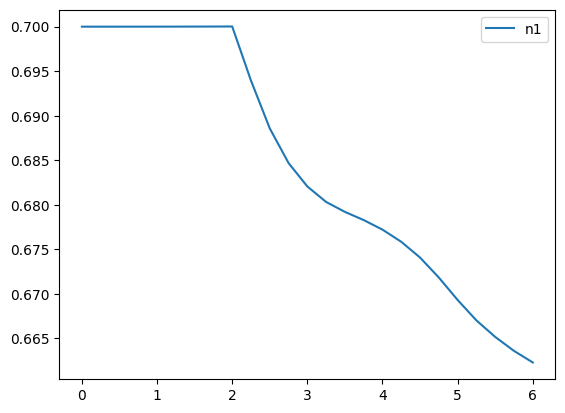

In [9]:
for k in ['n1']:
    plt.plot(ts, traces[k], label=k)
plt.legend()

In [23]:
NW = 4
D = 32
U = 3.05
vS = 0.25
alpha = 0.7
sym = 'Z2'
nn = 0 if sym == 'Z2' else NW + 2

H0, s2i, i2s = Hamiltonian_dpt_4U_mixed(NW, 0, 0, [0, 10000], 0, U * (2 * alpha - 1), sym=sym)
qI, qc, qcp, qn, dx, dn1, dn2, dI, m12, m21 = local_operators(sym=sym)
psi = mps.random_mps(H0, n=nn)
opts_svd = {"D_total": D}
info = mps.dmrg_(psi, H0, method='2site', opts_svd=opts_svd, max_sweeps=100, Schmidt_tol=1e-10)
print(info)

sd = s2i['D1']
O = (np.sqrt(alpha) * dn1 + np.sqrt(1 - alpha) * m12)
O = mps.product_mpo(sd * [qI] + [O] + (len(H0) - 1 - sd) * [qI])
psi = O @ psi
psi.canonize_(to='last')
psi.canonize_(to='first')

print(mps.measure_1site(psi, dn1, psi, sites=sd))
print(mps.measure_1site(psi, dn2, psi, sites=sd))
oo = mps.measure_1site(psi, qn, psi, sites=list(range(1, len(H0) + 1)))


DMRG_out(sweeps=100, method='2site', energy=-7.369464406779366, denergy=2.815525590449397e-13, max_dSchmidt=1.4592389192863987e-08, max_discarded_weight=np.float64(0.00024856594338630686))
0.6999999999999995
0.29999999999999977


In [ ]:
H1, s2i, i2s = Hamiltonian_dpt_4U_mixed(NW, 0, 0, [0, 0], 0, U, sym=sym)
H2, s2i, i2s = Hamiltonian_dpt_4U_mixed(NW, 0, 0, [0, 0], vS, U, sym=sym)
dt = 0.06126
tswitch, tfin = 2, 6

traces2 = {'n1': [], 'n2': [], 'm12': [], 'S1': [], 'S2': [], 'S3': [], 'S4': [], 'ent0': [], 'entS': []}
ts = []

for t0, t1, H in [(0, tswitch, H1), (tswitch, tfin, H2)]:
    times = np.linspace(t0, t1, int((t1 - t0) * 4) + 1)
    for step in mps.tdvp_(psi, H, times, method='2site', dt=dt, opts_svd=opts_svd, yield_initial=True):
        print(step)
        ts.append(step.tf)
        traces2['n1'].append(mps.measure_1site(psi, dn1, psi, sites=sd).real)
        traces2['n2'].append(mps.measure_1site(psi, dn2, psi, sites=sd).real)
        traces2['m12'].append(mps.measure_1site(psi, m12, psi, sites=sd).real)
        for ind in ['S1', 'S2', 'S3', 'S4']:
            traces2[ind].append(mps.measure_1site(psi, qn, psi, sites=s2i[ind]).real)

        ent = psi.get_entropy()
        traces2['ent0'].append(ent[sd+1])
        traces2['entS'].append(ent[s2i['S2']+1])


TDVP_out(ti=np.float64(0.0), tf=np.float64(0.0), time_independent=True, dt=0.06126, steps=0)
TDVP_out(ti=np.float64(0.0), tf=np.float64(0.25), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(0.25), tf=np.float64(0.49999999999999994), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(0.5), tf=np.float64(0.7500000000000002), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(0.75), tf=np.float64(1.0000000000000002), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(1.0), tf=np.float64(1.2500000000000002), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(1.25), tf=np.float64(1.5000000000000002), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(1.5), tf=np.float64(1.7500000000000002), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(1.75), tf=np.float64(2.0), time_independent=True, dt=np.float64(0.05), step

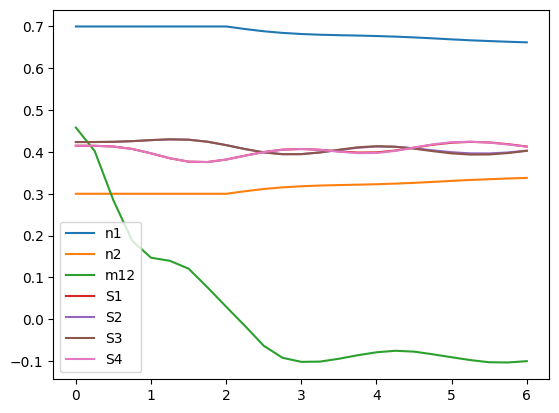

In [12]:
for k in ['n1', 'n2', 'm12', 'S1', 'S2', 'S3', 'S4']:
    plt.plot(ts, traces2[k], label=k)
plt.legend()

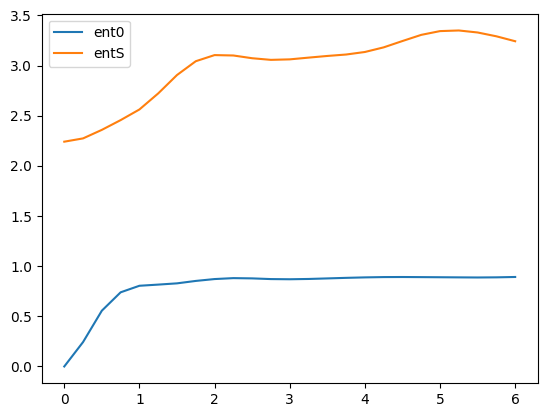

In [13]:
for k in ['ent0', 'entS']:
    plt.plot(ts, traces2[k], label=k)
plt.legend()

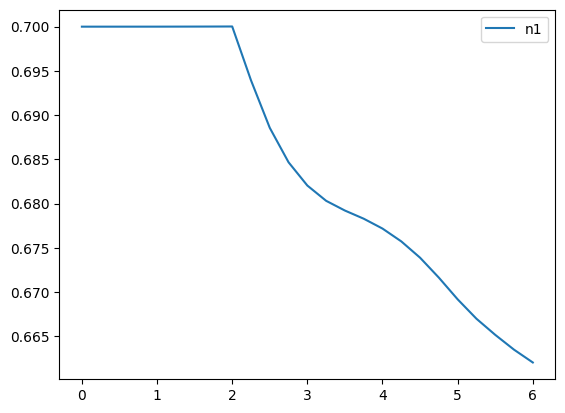

In [14]:
for k in ['n1']:
    plt.plot(ts, traces2[k], label=k)
plt.legend()

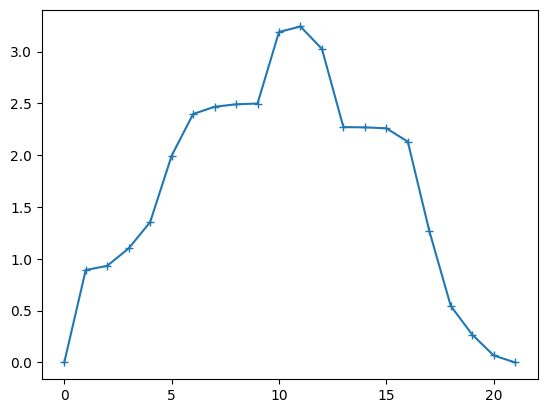

In [16]:
plt.plot(psi.get_entropy(), '-+')

In [8]:
NW = 8
D = 32
U = 3.05
vS = 0.25
alpha = 0.7
sym = 'Z2'
nn = 0 if sym == 'Z2' else NW + 2

H0, s2i, i2s = Hamiltonian_dpt_4U_momentum(NW, 0, 0, [0, 10000], 0, U * (2 * alpha - 1), sym=sym)
qI, qc, qcp, qn, dx, dn1, dn2, dI, m12, m21 = local_operators(sym=sym)
psi = mps.random_mps(H0, n=nn)
opts_svd = {"D_total": D}
info = mps.dmrg_(psi, H0, method='2site', opts_svd=opts_svd, max_sweeps=100, Schmidt_tol=1e-10)
print(info)

sd = s2i['D1']
O = (np.sqrt(alpha) * dn1 + np.sqrt(1 - alpha) * m12)
O = mps.product_mpo(sd * [qI] + [O] + (len(H0) - 1 - sd) * [qI])
psi = O @ psi
psi.canonize_(to='last')
psi.canonize_(to='first')

print(mps.measure_1site(psi, dn1, psi, sites=sd))
print(mps.measure_1site(psi, dn2, psi, sites=sd))
oo = mps.measure_1site(psi, qn, psi, sites=list(range(1, len(H0) + 1)))


DMRG_out(sweeps=14, method='2site', energy=-12.476376555692338, denergy=3.552713678800501e-15, max_dSchmidt=8.288370540448996e-11, max_discarded_weight=np.float64(2.8790490770388254e-05))
0.6999999999999995
0.2999999999999998


In [9]:
H1, s2i, i2s = Hamiltonian_dpt_4U_momentum(NW, 0, 0, [0, 0], 0, U, sym=sym)
H2, s2i, i2s = Hamiltonian_dpt_4U_momentum(NW, 0, 0, [0, 0], vS, U, sym=sym)
dt = 0.06126
tswitch, tfin = 2, 6

traces2 = {'n1': [], 'n2': [], 'm12': [], 'S1': [], 'S2': [], 'S3': [], 'S4': [], 'ent0': [], 'entS': []}
ts = []

for t0, t1, H in [(0, tswitch, H1), (tswitch, tfin, H2)]:
    times = np.linspace(t0, t1, int((t1 - t0) * 4) + 1)
    for step in mps.tdvp_(psi, H, times, method='2site', dt=dt, opts_svd=opts_svd, yield_initial=True):
        print(step)
        ts.append(step.tf)
        traces2['n1'].append(mps.measure_1site(psi, dn1, psi, sites=sd).real)
        traces2['n2'].append(mps.measure_1site(psi, dn2, psi, sites=sd).real)
        traces2['m12'].append(mps.measure_1site(psi, m12, psi, sites=sd).real)
        # for ind in ['S1', 'S2', 'S3', 'S4']:
        #     traces2[ind].append(mps.measure_1site(psi, qn, psi, sites=s2i[ind]).real)

        ent = psi.get_entropy()
        traces2['ent0'].append(ent[sd+1])
        #traces2['entS'].append(ent[s2i['S2']+1])


TDVP_out(ti=np.float64(0.0), tf=np.float64(0.0), time_independent=True, dt=0.06126, steps=0)
TDVP_out(ti=np.float64(0.0), tf=np.float64(0.25), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(0.25), tf=np.float64(0.49999999999999994), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(0.5), tf=np.float64(0.7500000000000002), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(0.75), tf=np.float64(1.0000000000000002), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(1.0), tf=np.float64(1.2500000000000002), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(1.25), tf=np.float64(1.5000000000000002), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(1.5), tf=np.float64(1.7500000000000002), time_independent=True, dt=np.float64(0.05), steps=5)
TDVP_out(ti=np.float64(1.75), tf=np.float64(2.0), time_independent=True, dt=np.float64(0.05), step

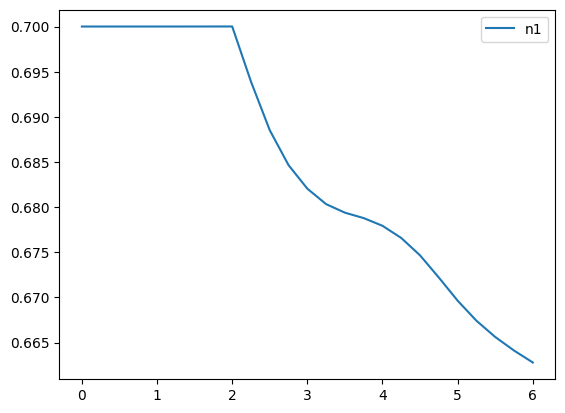

In [10]:
for k in ['n1']:
    plt.plot(ts, traces2[k], label=k)
plt.legend()

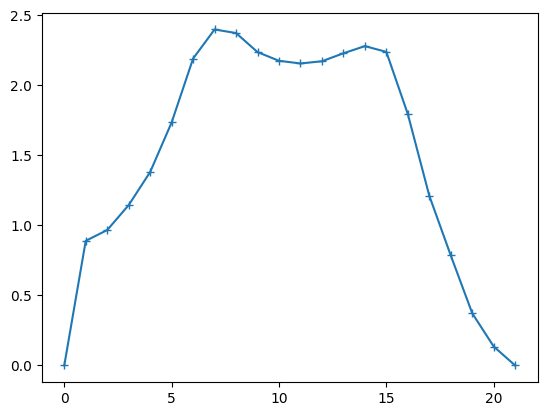

In [11]:
plt.plot(psi.get_entropy(), '-+')